In [3]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [5]:
# parseFasta(data) credit to Luke
def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])
    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

# this method credit to Zhiwen
def get_kmer_table(paths,k_min,k_max):
    genes,gene_len = read_fasta(paths)
    count_vect = CountVectorizer(analyzer='char', ngram_range=(k_min, k_max))
    X = count_vect.fit_transform(genes)
    chars = count_vect.get_feature_names()
    kmers = X.toarray()
    kmer_freq = []
    for i in range(len(genes)):
        kmer_freq.append(kmers[i] / gene_len[i])
    input = pd.DataFrame(kmer_freq, columns=chars)
    return input

# this method credit to Zhiwen
def get_gene_sequences(filename):
    genes = []
    for record in SeqIO.parse(filename, "fasta"):
        genes.append(str(record.seq))
    return genes

# this method credit to Zhiwen
# genes: a list of gene sequences, which can directly be generated from get_gene_sequences().
def get_gene_len(genes):
    gene_len = []

    for i in range(len(genes)):
        gene_len.append(len(genes[i]))
    return gene_len

# this method credit to Zhiwen
def read_fasta(paths):
    all_genes = []
    all_gene_len = []
    
    for path in paths:
        virus = parseFasta(path)
        virus = virus.drop_duplicates(keep="last")
        genes = list(virus['Sequence'])
        genes_seq = get_gene_sequences(path)
        gene_len = get_gene_len(genes_seq)
        all_genes = all_genes + genes_seq
        all_gene_len = all_gene_len + gene_len
    return all_genes,all_gene_len

# this method takes predits the input and make prediction using spectral clustering
# paths: a list of strings. contains file paths
# k_min: int. min of kmer
# k_max: int. max of kmer
# num_cluster: int. number of clusters
# assignLabels: a string. the way to assign label at the final stage of spectral clustering. Can be "kmeans" or "discretize"
def spectral_clustering(num_cluster, assignLabels, paths, k_min = 2, k_max = 3, seed = 0):
    kmer_table = get_kmer_table(paths, k_min, k_max)
    spectral_clustering = SpectralClustering(n_clusters= num_cluster, assign_labels = assignLabels, random_state = seed)
    labels = spectral_clustering.fit_predict(kmer_table)
    return labels
# this method takes prints the spectral clustering result by using PCA
# paths: a list of strings. contains file paths
# k_min: int. min of kmer
# k_max: int. max of kmer
# num_cluster: int. number of clusters
# assignLabels: a string. the way to assign label at the final stage of spectral clustering. Can be "kmeans" or "discretize"
def PCA_show_spectural_clustering(num_cluster, assignLabels, paths, k_min=2, k_max=3, seed=0):
    kmer_table = get_kmer_table(paths, k_min, k_max);
    prediction = SpectralClustering(n_clusters=num_cluster, assign_labels=assignLabels, random_state=seed).fit_predict(
        kmer_table)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(kmer_table)
    d = {'dimension1': pca_result[:, 0], 'dimension2': pca_result[:, 1], 'label': prediction}
    df = pd.DataFrame(d)
    for i in range(num_cluster):
        label = df.loc[df['label'] == i]
        color = 'C' + str(i)
        plt.scatter(label['dimension1'].tolist(), label['dimension2'].tolist(), c=color)
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('Unsupervised Spectral clustring with ' + assignLabels + ' assign label method')
# NOTE: do we also want to show users the optimal k_min and k_max for users here?
def intuitive_semi_supervised(num_cluster, file_path, label_path, assignLabels = "none", k_min=2, k_max=3, seed=699):
    labels = pd.read_csv(label_path)
    label_list = labels["Labels"].to_list()
    total_len = len(label_list)
    unknown_label = -1
    total_labeled = 0
    optimal_accuracy = 0
    optimal_k_min = 0
    optimal_k_max = 0
    for i in label_list:
        if label_list[i] != unknown_label:
            total_labeled = total_labeled + 1
    res = [0] * total_len
    
    if (assignLabels == "none"):
        
        for i in range(k_min, k_max + 1):
            for j in range(i, k_max + 1):
                temp_k_min = i
                temp_k_max = j
                kmer_table = get_kmer_table(file_path, temp_k_min, temp_k_max)
                spectral_clustering = SpectralClustering(n_clusters=num_cluster, assign_labels="kmeans",
                                                     random_state=seed)
                labels = spectral_clustering.fit_predict(kmer_table)
                correct_count = 0
                temp_accuracy = 0
                for k in range(len(label_list)):
                    if (label_list[k] != unknown_label):
                        if (label_list[k] == labels[k]):
                            correct_count += 1
                temp_accuracy = correct_count / total_labeled
                if (temp_accuracy > optimal_accuracy):
                    optimal_accuracy = temp_accuracy
                    optimal_k_min = i
                    optimal_k_max = j
                    res = labels
                
        for i in range(k_min, k_max + 1):
            for j in range(i, k_max + 1):
                temp_k_min = i
                temp_k_max = j
                kmer_table = get_kmer_table(file_path, temp_k_min, temp_k_max)
                spectral_clustering = SpectralClustering(n_clusters=num_cluster, assign_labels="discretize",
                                                     random_state=seed)
                labels = spectral_clustering.fit_predict(kmer_table)
                correct_count = 0
                temp_accuracy = 0
                for k in range(len(label_list)):
                    if (label_list[k] != unknown_label):
                        if (label_list[k] == labels[k]):
                            correct_count += 1
                temp_accuracy = correct_count / total_labeled
                if (temp_accuracy > optimal_accuracy):
                    optimal_accuracy = temp_accuracy
                    optimal_k_min = i
                    optimal_k_max = j
                    res = labels
        print("The optimal accuracy based on labeled sequences is: " + str(optimal_accuracy))
        print("The optimal k_min is: " + str(optimal_k_min))
        print("The optimal k_max is: " + str(optimal_k_max))
    else:
        for i in range(k_min, k_max + 1):
            for j in range(i, k_max + 1):
                temp_k_min = i
                temp_k_max = j
                kmer_table = get_kmer_table(file_path, temp_k_min, temp_k_max)
                spectral_clustering = SpectralClustering(n_clusters=num_cluster, assign_labels=assignLabels,
                                                     random_state=seed)
                labels = spectral_clustering.fit_predict(kmer_table)
                correct_count = 0
                temp_accuracy = 0
                for k in range(len(label_list)):
                    if (label_list[k] != unknown_label):
                        if (label_list[k] == labels[k]):
                            correct_count += 1
                temp_accuracy = correct_count / total_labeled
                if (temp_accuracy > optimal_accuracy):
                    optimal_accuracy = temp_accuracy
                    optimal_k_min = i
                    optimal_k_max = j
                    res = labels
        print("The optimal accuracy based on labeled sequences is: " + str(optimal_accuracy))
        print("The optimal k_min is: " + str(optimal_k_min))
        print("The optimal k_max is: " + str(optimal_k_max))
    return res
def PCA_show_semi_spectural_clustering(num_cluster, file_path, label_path, assignLabels = "none", k_min=2, k_max=3, seed=699):
    prediction = intuitive_semi_supervised(num_cluster,  file_path, label_path, assignLabels, k_min, k_max, seed)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(kmer_table)
    d = {'dimension1': pca_result[:, 0], 'dimension2': pca_result[:, 1], 'label': prediction}
    df = pd.DataFrame(d)
    for i in range(num_cluster):
        label = df.loc[df['label'] == i]
        color = 'C' + str(i)
        plt.scatter(label['dimension1'].tolist(), label['dimension2'].tolist(), c=color)
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.title('Semi-supervised Spectral clustring with ' + assignLabels + ' assign label method')

The optimal accuracy based on labeled sequences is: 1.0
The optimal k_min is: 2
The optimal k_max is: 2
The optimal accuracy based on labeled sequences is: 1.0
The optimal k_min is: 2
The optimal k_max is: 2


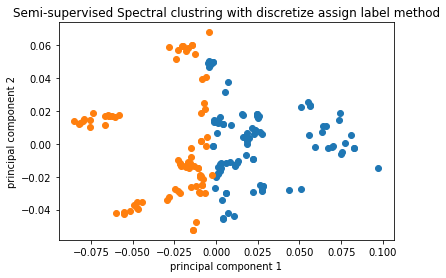

In [19]:
new_paths = ["combined_Bat_Cat_flu.fa"]
k_min = 2
k_max = 6
num_class = 2
kmer_table = get_kmer_table(new_paths, k_min, k_max)
result = intuitive_semi_supervised(num_class,new_paths,"labels_ten_percent_only0s.csv","discretize",k_min,k_max)
PCA_show_semi_spectural_clustering(num_class,new_paths,"labels_ten_percent_only0s.csv","discretize",k_min,k_max)

In [21]:
bat_len = len(get_gene_sequences("bat_flu.fa"))

cat_len = len(get_gene_sequences("cat_flu.fa"))

zeros = [0]*bat_len
labels1 = np.append(zeros, [1]*cat_len, axis=None)
temp_accuracy = 1 - sum(abs(labels1 - result))/(bat_len+cat_len)
print("The accuracy based on all true label is: " + str(temp_accuracy) + " for ten percent only 0 labeled dataset.")

The accuracy based on all true label is: 0.702247191011236 for ten percent only 0 labeled dataset.


The optimal accuracy based on labeled sequences is: 0.7647058823529411
The optimal k_min is: 3
The optimal k_max is: 3
The optimal accuracy based on labeled sequences is: 0.7647058823529411
The optimal k_min is: 3
The optimal k_max is: 3


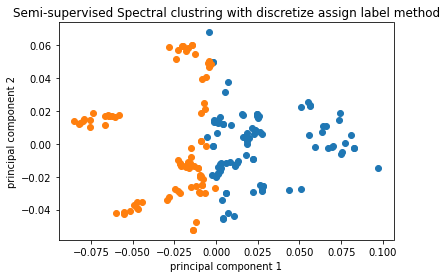

In [22]:
new_paths = ["combined_Bat_Cat_flu.fa"]
k_min = 2
k_max = 6
num_class = 2
kmer_table = get_kmer_table(new_paths, k_min, k_max)
result = intuitive_semi_supervised(num_class,new_paths,"labels_ten_percent.csv","discretize",k_min,k_max)
PCA_show_semi_spectural_clustering(num_class,new_paths,"labels_ten_percent.csv","discretize",k_min,k_max)

In [24]:
bat_len = len(get_gene_sequences("bat_flu.fa"))

cat_len = len(get_gene_sequences("cat_flu.fa"))

zeros = [0]*bat_len
labels1 = np.append(zeros, [1]*cat_len, axis=None)
temp_accuracy = 1 - sum(abs(labels1 - result))/(bat_len+cat_len)
print("The accuracy based on all true label is: " + str(temp_accuracy) + " for ten percent labeled dataset.")

The accuracy based on all true label is: 0.7303370786516854 for ten percent labeled dataset.


The optimal accuracy based on labeled sequences is: 0.7415730337078652
The optimal k_min is: 2
The optimal k_max is: 2
The optimal accuracy based on labeled sequences is: 0.7415730337078652
The optimal k_min is: 2
The optimal k_max is: 2


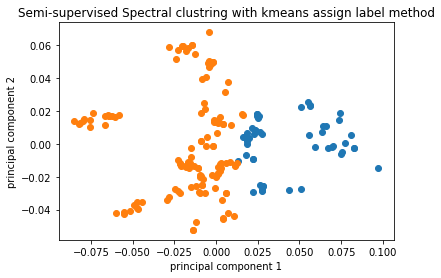

In [25]:
new_paths = ["combined_Bat_Cat_flu.fa"]
k_min = 2
k_max = 6
num_class = 2
kmer_table = get_kmer_table(new_paths, k_min, k_max)
result = intuitive_semi_supervised(num_class,new_paths,"labels_fifty_percent.csv","kmeans",k_min,k_max)
PCA_show_semi_spectural_clustering(num_class,new_paths,"labels_fifty_percent.csv","kmeans",k_min,k_max)

In [28]:
temp_accuracy = 1 - sum(abs(labels1 - result))/(bat_len+cat_len)
temp_accuracy
print("The accuracy based on all true label is: " + str(temp_accuracy) + " for fifty percent labeled dataset.")

The accuracy based on all true label is: 0.747191011235955 for fifty percent labeled dataset.


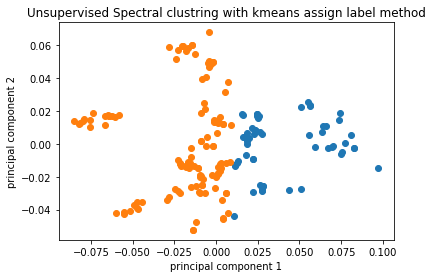

In [35]:
result = spectral_clustering(2, "kmeans", new_paths, 2, 6)
PCA_show_spectural_clustering(2, "kmeans", new_paths, 2, 6)